<a href="https://colab.research.google.com/github/Sooryak12/PS-1-CycleGAN/blob/main/Generating_Optical_Images_with_Trained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Drive :

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Installing Necessary Libraries :

In [ ]:
!pip install rasterio

!pip install split-folders

!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 69.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing Necessary Libraries :

In [ ]:
import splitfolders
import shutil

from os import listdir
from numpy import asarray
from numpy import vstack
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img
from numpy import savez_compressed
from tqdm import tqdm
import rasterio
import os
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.plot import show

# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from math import log10,sqrt
import skimage
from skimage.metrics import structural_similarity as ssim

In [ ]:
def PSNR(original, compressed):
    """ Function to calculate PSNR value"""
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

## Paired Data :

In [ ]:
eval_rgb = os.listdir("/content/data2/rgb")
eval_sar = os.listdir("/content/data2/sar")

In [ ]:
print(sorted(eval_rgb))
print(sorted(eval_sar))

['SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8683.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804125251_20190804125541_tile_6882.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804130422_20190804130643_tile_3177.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804132547_20190804132826_tile_10878.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804134228_20190804134450_tile_1872.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804143846_20190804144102_tile_5701.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804143846_20190804144102_tile_5706.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804143846_20190804144102_tile_5707.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804144353_20190804144627_tile_9931.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804145216_20190804145445_tile_6520.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190822065725_20190822065959_tile_7283.tif', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190822070610_20190822070846_tile_3722.tif', 'SN6_Train_AOI_11_Rotterda

In [ ]:
d=[]
for i,j in zip(eval_rgb,eval_sar):
  d.append((j,i))

# Loading Images and Generating Images for Corresponding SAR Images :

### Functions to load Images :

In [ ]:

def load_image_predict(path, size=(400,400)):
  """ Function to load and resize rgb image"""
      pixels = load_img(path, target_size=size)
      # convert to numpy array
      pixels = img_to_array(pixels)
      # store
      return pixels

def load_images_sar(filename, size=(400,400)):
  """ Function to load SAR Intensity image and resize it"""
    with rasterio.open(filename) as src:
          img_data = src.read(
            out_shape=(
              src.count,
              400,
              400),
            resampling=Resampling.bilinear )
          img_data = img_data[:3]
          img_data = np.moveaxis(img_data, 0,-1) 
    return img_data

### Loading and Compiling trained model ( We are using only the SAR to RGB Generator here)

In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
model_536 ='/content/drive/MyDrive/g_model_AtoB_000536.h5'
model_336 ="/content/drive/MyDrive/g_model_AtoB_000366.h5"
model_AtoB = load_model(model_336, cust)   # Loading Model
opt = Adam(lr=0.0002, beta_1=0.5)
  # compile model with weighting of least squares loss and L1 loss
model_AtoB.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)

### Training the model on all paired data :

In [ ]:
psnr_values=[]
ssim_values=[]
new_images=[]
rgb_images=[]
sar_images=[]
upscale_factor=1/2

# translate image
# image_tar = model_AtoB.predict(image_src)
# # scale from [-1,1] to [0,1]
for sar_path , rgb_path in d:
  sar_img = load_images_sar(os.path.join("data2/sar",sar_path))
  rgb_img = load_image_predict(os.path.join("data2/rgb",rgb_path))

  sar_images.append(sar_img)
  rgb_images.append(rgb_img)

  sar_img = np.expand_dims(sar_img,axis=0)
  image_tar = model_AtoB.predict(sar_img)

  image_tar = (image_tar + 1) / 2.0
  new_images.append(image_tar[0])

  psnr_values.append(PSNR(rgb_img.astype("uint8")/255,image_tar[0]))
  ssim_values.append(ssim(rgb_img.astype("uint8"),image_tar[0],multichannel=True))








/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.8/dist-packages/skimage/metrics/_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


1/1 [==============================] - 0s 22ms/step


## Plotting the Images :

In [ ]:
def image_plot(i):
  r = rgb_images[i].astype("uint8")
  s = sar_images[i].astype("uint8")
  o = new_images[i]
  plt.rcParams["figure.figsize"] = [30,30]
  plt.rcParams["figure.autolayout"] = True  
  plt.subplot(1, 3, 1)
  plt.imshow(s)
  plt.gca().set_title("SAR Image",fontsize = 30)
  plt.subplot(1, 3, 2)
  plt.imshow(o)
  plt.gca().set_title("Generated Optical Image",fontsize = 30)
  plt.subplot(1, 3, 3)
  plt.imshow(r)
  plt.gca().set_title("Actual RGB Image",fontsize = 30)

  plt.show()
  print("PSNR of the image :",psnr_values[i])
  print("SSIM  of the image :",ssim_values[i])
  print(np.mean(psnr_values))
  print(np.mean(ssim_values))
  


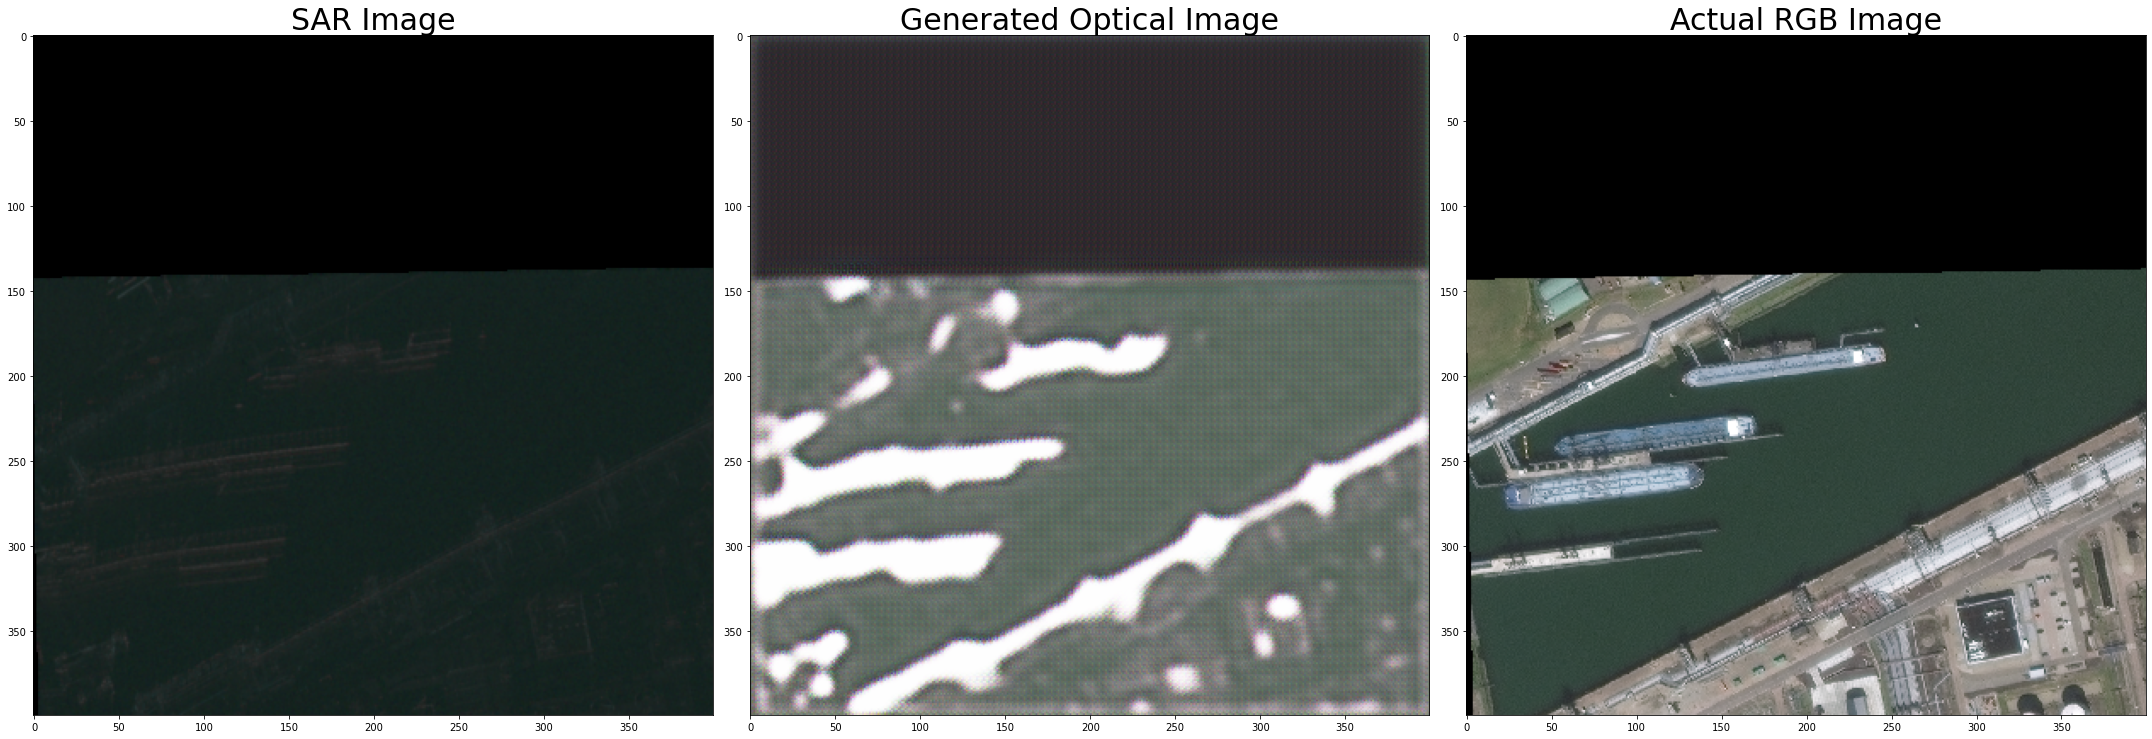

PSNR of the image : 60.17140657127909
SSIM  of the image : 0.34450681075849293
59.842413198151355
0.348519877579335


In [ ]:
image_plot(5)

In [ ]:
print(ssim_values)
print(psnr_values)


[0.23341235193370058, 0.3793258210994945, 0.27540810832776, 0.4709655391755465, 0.40985588070839163, 0.34522571192827906, 0.38129159204042895, 0.2980921359541204, 0.20141486103707087, 0.4689350077154126, 0.2537093996781763, 0.46199013863597344, 0.3637333750146521, 0.38499117235205044, 0.28386684969073767, 0.32965434675192046, 0.4377285236551452, 0.4060415187988953, 0.42116417013674773, 0.18477666606978663, 0.3781067362058191, 0.3542994481632566, 0.3436173550192431, 0.2875350557257107, 0.28801999169566495, 0.3444046501655416, 0.3285441018952268, 0.45413414110636235, 0.28345379222740164, 0.42269299781518416, 0.4546504702484684, 0.4562841808622818, 0.4646377969643243, 0.201263898042512, 0.3068867651098635, 0.370050875817624, 0.26534964997884086, 0.4617155306011378, 0.2900383889525257, 0.27780193141117915, 0.4774838557863379, 0.32986017474474333, 0.377811120628975, 0.1926622423304251, 0.34493859428369134, 0.17964290084892473, 0.3448587826854192, 0.33806309691026787, 0.38994586485041155, 0.